In [1]:
import os
import sys
import scipy.io
import scipy.misc
import imageio
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from StyleTransferUtilities import *
# from functions import *
import numpy as np
import tensorflow as tf

%matplotlib inline

In [2]:
# too large pretrained model
# model = load_vgg_model("http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat") 
# print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_4': <tf.Tensor 'Relu_11:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv5_3': <tf.Tensor 'Relu_14:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv5_2': <tf.Tensor 'Relu_13:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1,

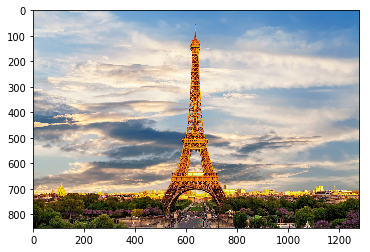

In [3]:
content_image = imageio.imread("eiffeltower.jpg")
imshow(content_image)

In [4]:
content_image.shape

(853, 1280, 3)

In [5]:
# style_image = imageio.imread("style1.jpg")
# imshow(style_image)

The shape of the content and the style image needs to be the same

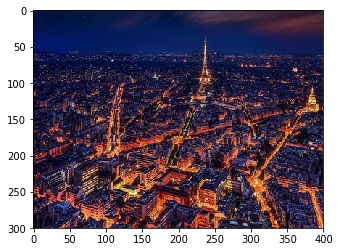

In [9]:
style_image = imageio.imread("style2.jpg")
imshow(style_image)

In [10]:
style_image.shape

(300, 400, 3)

#### Computing Content cost

In [11]:
def compute_content_cost(a_C, a_G):
    # Retrieving dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshaping a_C and a_G
    a_C_unrolled = tf.transpose(tf.reshape(a_C, [-1]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G, [-1]))
    
    # compute the cost with tensorflow
    J_content = tf.reduce_sum((a_C_unrolled - a_G_unrolled)**2) / (4 * n_H * n_W * n_C)
    
    return J_content

In [12]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.76559


##### Style Matrix

In [13]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

In [14]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

GA = [[  6.42230511  -4.42912197  -2.09668207]
 [ -4.42912197  19.46583748  19.56387138]
 [ -2.09668207  19.56387138  20.6864624 ]]


##### Style Cost

In [15]:
def compute_layer_style_cost(a_S, a_G):
    # Retrieving dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshaping the images to have them of shape (n_C, n_H*n_W) 
    a_S = tf.reshape(a_S, [n_H*n_W, n_C])
    a_G = tf.reshape(a_G, [n_H*n_W, n_C])

    GS = gram_matrix(tf.transpose(a_S)) 
    
    GG = gram_matrix(tf.transpose(a_G))

    # Computing the loss 
    J_style_layer = tf.reduce_sum((GS - GG)**2) / (4 * n_C**2 * (n_W * n_H)**2)
    
    return J_style_layer

In [16]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.19028


##### Style Weights
$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`

In [17]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [18]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [19]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    ### START CODE HERE ### (≈1 line)
    J = alpha * J_content + beta * J_style
    ### END CODE HERE ###
    
    return J

In [20]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


##### Solving Optimization problem

In [21]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [25]:
content_image = imageio.imread("eiffel-tower-small.jpg")
content_image = reshape_and_normalize_image(content_image)

style_image = imageio.imread("style2.jpg")
style_image = reshape_and_normalize_image(style_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


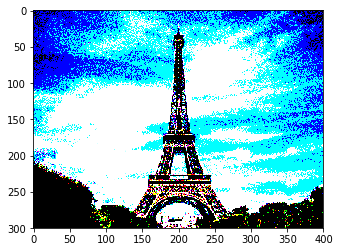

In [26]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

##### WARNING: This only works for images of size 300x400

In [27]:
# model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat") # too-large

In [28]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [29]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [30]:
J = total_cost(J_content, J_style,  alpha = 10, beta = 40)

In [31]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [32]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        _ = sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])
        
        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [34]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 1.84981e+10
content cost = 11008.8
style cost = 4.6245e+08
Iteration 20 :
total cost = 4.44227e+09
content cost = 20694.2
style cost = 1.11052e+08
Iteration 40 :
total cost = 1.74379e+09
content cost = 23701.5
style cost = 4.35887e+07
Iteration 60 :
total cost = 9.19676e+08
content cost = 24984.0
style cost = 2.29857e+07
Iteration 80 :
total cost = 5.98036e+08
content cost = 25694.8
style cost = 1.49445e+07
Iteration 100 :
total cost = 4.36363e+08
content cost = 26109.9
style cost = 1.09025e+07
Iteration 120 :
total cost = 3.41018e+08
content cost = 26448.8
style cost = 8.51885e+06
Iteration 140 :
total cost = 2.79772e+08
content cost = 26723.5
style cost = 6.98763e+06
Iteration 160 :
total cost = 2.36529e+08
content cost = 26975.9
style cost = 5.90649e+06
Iteration 180 :
total cost = 2.05086e+08
content cost = 27209.1
style cost = 5.12035e+06


array([[[[ -23.58234596,  -63.848629  ,   64.10695648],
         [ -89.90574646,  -87.3447876 ,  -37.18384933],
         [  -0.88550788,    0.50675988,   52.64107132],
         ..., 
         [  20.45186996,  -37.30368423,   96.96269989],
         [  21.42758751,   23.61355782,  103.45096588],
         [  41.22603226,   57.393116  ,  116.49118805]],

        [[ -17.42524529,  -59.3399353 ,   51.55954361],
         [ -86.69692993, -102.92945862,  -41.24581909],
         [ -17.67238045,   -9.08172607,   39.97141647],
         ..., 
         [ -96.6135788 ,  -80.21343231,   -1.95652068],
         [-134.43389893,  -82.35881805,   47.40507889],
         [ -76.4256897 ,  -91.77361298,   67.43069458]],

        [[  51.82165909,   30.54666138,   65.67649078],
         [ -28.50426674,  -65.39057922,   14.11749172],
         [ -40.21110916,  -18.01221466,    8.25663662],
         ..., 
         [ -29.16782951,  -64.30082703,   45.26255798],
         [ -30.76218033,  -78.81515503,   77.71668243],

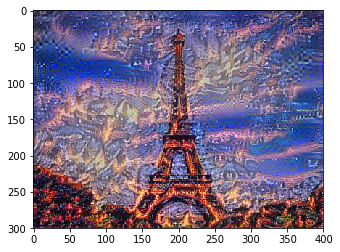

In [35]:
output200_image = imageio.imread("output/generated_image.jpg")
imshow(output200_image)